In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout, Bidirectional, Input, Concatenate
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, Normalizer

Using TensorFlow backend.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20,4/20/20,4/21/20,4/22/20,4/23/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,714,784,840,906,933,996,1026,1092,1176,1279
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,475,494,518,539,548,562,584,609,634,663
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,2070,2160,2268,2418,2534,2629,2718,2811,2910,3007
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,659,673,673,696,704,713,717,717,723,723
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,24,24,24,24,25,25


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df_wdi = pd.read_csv('datasets/world_development_index_clean.csv')

In [6]:
df_wdi.head()

,Country Name,"Birth rate (per 1,000)","Death, by communicable diseases and others (%)","Death, by non-communicable diseases (%)","Health expenditure per capita, PPP ($)","Death rate (per 1,000)","Hospital beds (per 1,000)","International tourism, number of arrivals",Life expectancy at birth (years),"Mortality rate, adult, female (per 1,000)","Mortality rate, adult, male (per 1,000)","Nurses and midwives (per 1,000)",People using at least basic sanitation services (%),Population ages 65+ (%),Population density (people per sq.km),Population,Smoking prevalence (ages 15+)
0,Hungary,9.700,1.8,93.8,1963.162630,13.500,7.000000,17552000.0,76.063415,80.586,168.058,6.6425,97.990873,19.157725,107.906606,9768785.0,30.6
1,Colombia,15.098,10.1,74.8,829.802922,5.503,1.500000,3904000.0,76.925000,87.205,187.406,1.2627,89.625358,8.478047,44.748702,49648685.0,9.0
2,Germany,9.500,4.8,91.2,5463.330652,11.300,8.300000,38881000.0,80.990244,50.173,92.460,13.1967,99.225038,21.461962,237.370970,82927922.0,30.6
3,Slovenia,9.800,5.0,88.4,2772.229776,9.900,4.600000,4425000.0,81.175610,43.961,94.604,9.6800,99.109568,19.606880,102.639860,2067372.0,22.5
4,Rwanda,32.062,42.4,44.0,130.380629,5.308,0.661133,932000.0,68.341000,164.756,219.354,0.8307,66.573842,2.938196,498.659870,12301939.0,12.3


In [7]:
# df = df.join(df_wdi.set_index('Country Name'), on='Country/Region').dropna()

In [8]:
# cols = df.columns[4:]

In [9]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
# df['Population'] = np.array([6.4 *(10**9) for x in range(len(df))])

df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


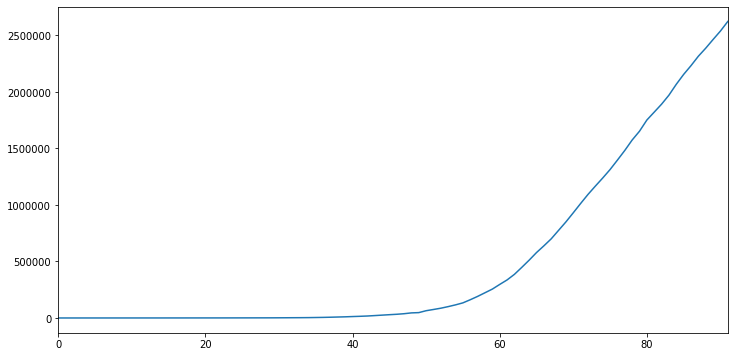

In [10]:
df['Confirmed'].plot(figsize=(12,6))

In [11]:
# df = df.dropna()

In [12]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [13]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [14]:
training_set = df[:train_index]

In [15]:
# sc = MinMaxScaler()
# sc = StandardScaler(with_mean=False)
sc = PowerTransformer(method='yeo-johnson', standardize=True)
# sc = Normalizer()
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))

In [16]:
training_set_scaled.shape

(73, 1)

In [17]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [18]:
print(X_train.shape, y_train.shape)

(53, 20, 1) (53,)


In [19]:
# X_train[0]

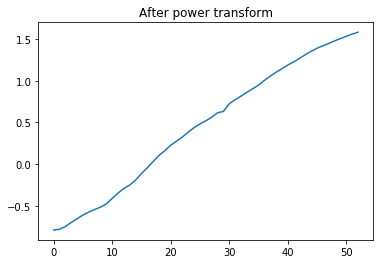

In [20]:
X_train[0]
plt.plot(y_train)
plt.title('After power transform')

plt.show()

In [21]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
73,2020-04-05,1166882,74
74,2020-04-06,1238466,75
75,2020-04-07,1313374,76
76,2020-04-08,1396995,77
77,2020-04-09,1482395,78


In [22]:
real_conf = testing_set['Confirmed'].values

In [23]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [24]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [25]:
# inputs
# total
print(X_test.shape)

(19, 20, 1)


In [26]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [27]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [28]:
model = Sequential()

model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

# population_input_layer = Input(shape=(1,))
# population_dense = Dense(32)(population_input_layer)

# input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
# lstm = LSTM(256)(input_layer)
# merge = Concatenate(axis=-1)([lstm,population_dense])
# dropout_lstm = Dropout(0.2)(merge)
# confirmed = Dense(1)(dropout_lstm)

# model = Model([input_layer,population_input_layer], confirmed)
# model.summary()

# model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)


In [29]:
# early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, mode='min')
plat = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1, factor=0.7)
cb = [checkpoint, plat]

In [30]:
history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
#                     validation_data = (X_test, Y_test),
                    validation_split = 0.1)

Train on 47 samples, validate on 6 samples
Epoch 1/200
47/47 [==============================] - ETA: 0s - loss: 0.682 - 1s 16ms/step - loss: 0.6089 - val_loss: 0.3988
Epoch 2/200
47/47 [==============================] - ETA: 0s - loss: 0.351 - 0s 3ms/step - loss: 0.3444 - val_loss: 0.1787
Epoch 3/200
47/47 [==============================] - ETA: 0s - loss: 0.318 - 0s 4ms/step - loss: 0.2944 - val_loss: 0.2099
Epoch 4/200
47/47 [==============================] - ETA: 0s - loss: 0.239 - 0s 4ms/step - loss: 0.2520 - val_loss: 0.1563
Epoch 5/200
47/47 [==============================] - ETA: 0s - loss: 0.235 - 0s 5ms/step - loss: 0.2178 - val_loss: 0.0424
Epoch 6/200
47/47 [==============================] - ETA: 0s - loss: 0.148 - 0s 3ms/step - loss: 0.1490 - val_loss: 0.0457
Epoch 7/200
47/47 [==============================] - ETA: 0s - loss: 0.142 - 0s 4ms/step - loss: 0.1374 - val_loss: 0.0438
Epoch 8/200
47/47 [==============================] - ETA: 0s - loss: 0.123 - 0s 3ms/step - loss

Epoch 60/200
47/47 [==============================] - ETA: 0s - loss: 0.086 - 0s 3ms/step - loss: 0.0712 - val_loss: 0.0016
Epoch 61/200
47/47 [==============================] - ETA: 0s - loss: 0.077 - 0s 4ms/step - loss: 0.0721 - val_loss: 0.0028
Epoch 62/200
47/47 [==============================] - ETA: 0s - loss: 0.043 - 0s 4ms/step - loss: 0.0395 - val_loss: 0.0034

Epoch 00062: ReduceLROnPlateau reducing learning rate to 1.977326610358432e-05.
Epoch 63/200
47/47 [==============================] - ETA: 0s - loss: 0.040 - 0s 4ms/step - loss: 0.0435 - val_loss: 0.0035
Epoch 64/200
47/47 [==============================] - ETA: 0s - loss: 0.077 - 0s 4ms/step - loss: 0.0791 - val_loss: 0.0030
Epoch 65/200
47/47 [==============================] - ETA: 0s - loss: 0.054 - 0s 4ms/step - loss: 0.0467 - val_loss: 0.0020
Epoch 66/200
47/47 [==============================] - ETA: 0s - loss: 0.071 - 0s 4ms/step - loss: 0.0668 - val_loss: 0.0013

Epoch 00066: ReduceLROnPlateau reducing learning r

47/47 [==============================] - ETA: 0s - loss: 0.037 - 0s 4ms/step - loss: 0.0452 - val_loss: 6.5162e-04

Epoch 00170: ReduceLROnPlateau reducing learning rate to 1.2993479847622779e-09.
Epoch 171/200
47/47 [==============================] - ETA: 0s - loss: 0.049 - 0s 4ms/step - loss: 0.0475 - val_loss: 6.5162e-04
Epoch 172/200
47/47 [==============================] - ETA: 0s - loss: 0.049 - 0s 4ms/step - loss: 0.0630 - val_loss: 6.5160e-04
Epoch 173/200
47/47 [==============================] - ETA: 0s - loss: 0.061 - 0s 4ms/step - loss: 0.0593 - val_loss: 6.5160e-04
Epoch 174/200
47/47 [==============================] - ETA: 0s - loss: 0.054 - 0s 4ms/step - loss: 0.0518 - val_loss: 6.5162e-04

Epoch 00174: ReduceLROnPlateau reducing learning rate to 9.095435737904722e-10.
Epoch 175/200
47/47 [==============================] - ETA: 0s - loss: 0.041 - 0s 4ms/step - loss: 0.0413 - val_loss: 6.5164e-04
Epoch 176/200
47/47 [==============================] - ETA: 0s - loss: 0.076 

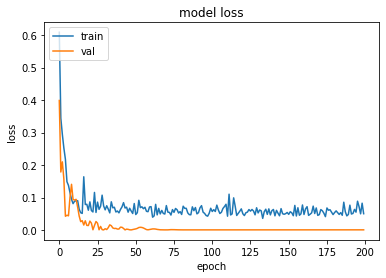

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [32]:
model.load_weights("model.h5")

In [33]:
predicted_conf = model.predict(X_test)

In [34]:
# predicted_conf=pd.DataFrame(predicted_conf)
# X_test[0]

In [35]:
sc.inverse_transform(predicted_conf)
# X_test
# X_train
# real_conf

array([[1167504.4],
       [1246926.4],
       [1324207.4],
       [1398930.9],
       [1471735.8],
       [1543619.8],
       [1615806.9],
       [1687900.6],
       [1760862.6],
       [1833302.1],
       [1903460.6],
       [1971260.6],
       [2038469.9],
       [2105842.8],
       [2172722.8],
       [2238961.8],
       [2303541.5],
       [2366245. ],
       [2426986.2]], dtype=float32)

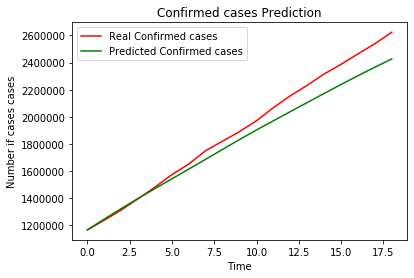

In [36]:
# plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

In [37]:
pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]
real_conf = np.array(real_conf)
# pred_conf
real_conf

array([1166882, 1238466, 1313374, 1396995, 1482395, 1574585, 1652636,
       1751587, 1821625, 1891889, 1971701, 2068018, 2155384, 2232929,
       2316273, 2387430, 2464238, 2539181, 2623844], dtype=int64)

In [38]:

print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1)))))

RMSLE =  0.04500557619562265


# Use old predictions as input for new predictions

In [39]:
training_set.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


In [40]:
inp = np.array([X_train[-1]])
inp

array([[[0.8144964 ],
        [0.86022791],
        [0.90363905],
        [0.94653361],
        [1.00345115],
        [1.05424241],
        [1.10136226],
        [1.14217627],
        [1.18729048],
        [1.22516837],
        [1.26656948],
        [1.31131767],
        [1.35129286],
        [1.38849875],
        [1.41785611],
        [1.44581818],
        [1.47641306],
        [1.50413061],
        [1.53139908],
        [1.55683769]]])

In [41]:
inp_pred = model.predict(inp)

In [42]:
inp_pred[0]

array([1.5780236], dtype=float32)

In [43]:
inp = list(inp[0])
inp.pop(0)

array([0.8144964])

In [44]:
inp.append(inp_pred)
# inp

In [45]:
# np.array([inp])

In [46]:
def gen_pred(inp, num):
    preds = []
    for n in range(num):     
        inp = np.array([inp])
        inp_pred = model.predict(inp) 
        preds.append(list(inp_pred[0]))
        inp = list(inp[0])
        inp.pop(0)
        inp.append(inp_pred)
    return preds


In [47]:
res = gen_pred(X_train[-1], len(real_conf))
# res

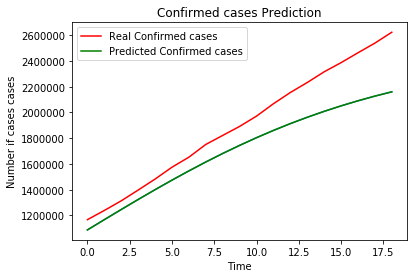

In [48]:
plt.plot(sc.inverse_transform(res))

plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(res), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()

plt.show()

In [49]:
print("RMSLE = ", np.sqrt(np.mean(np.square(np.log(sc.inverse_transform(res) + 1) - np.log(real_conf + 1)))))

RMSLE =  0.3384643312292133


# For each country

In [50]:
# pop = pd.read_csv('datasets\population_data.csv')
# pop.head()

In [51]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [52]:
country ='India'

In [53]:
temp = df_c[df_c['Country/Region'] == country]
temp = temp[temp['Confirmed'] > 0].fillna(0).reset_index()
# temp = temp[temp['Confirmed'] > 0].diff().fillna(0)
temp.head()

,index,Country/Region,Lat,Long,Date,Confirmed
0,1373,India,21.0,78.0,2020-01-30,1
1,1558,India,21.0,78.0,2020-01-31,1
2,1743,India,21.0,78.0,2020-02-01,1
3,1928,India,21.0,78.0,2020-02-02,2
4,2113,India,21.0,78.0,2020-02-03,3


In [54]:
temp['Day num'] = np.arange(1, len(temp)+1)
temp.tail()

,index,Country/Region,Lat,Long,Date,Confirmed,Day num
80,16173,India,21.0,78.0,2020-04-19,17615,81
81,16358,India,21.0,78.0,2020-04-20,18539,82
82,16543,India,21.0,78.0,2020-04-21,20080,83
83,16728,India,21.0,78.0,2020-04-22,21370,84
84,16913,India,21.0,78.0,2020-04-23,23077,85


In [55]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(y_pred + 1) - K.log(y_true + 1)))) 

In [56]:
def create_model():
    model = Sequential()

    model.add(LSTM(units = 256, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1))

    model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)
    
    return model

In [57]:
plat = ReduceLROnPlateau(monitor='loss', patience=4, verbose=0, factor=0.7)
cb = [plat]

In [58]:
countries = list(df_c['Country/Region'].unique())
len(countries)

184

In [59]:
num_epochs = 200
batch_size = 32
split = 0.8
window = 20

In [60]:
errs = []
for country in tqdm(countries):
    temp = df_c[df_c['Country/Region'] == country].reset_index()
    temp = temp[temp['Confirmed'] > 0].fillna(0)
    temp['Day num'] = np.arange(1, len(temp)+1)
    
    training = split
    total = temp.shape[0]
    train_index = int(total*training)
    
    training_set = temp[:train_index]
    
    sc = PowerTransformer(method='yeo-johnson', standardize=True)
    training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set[['Confirmed']]).values))
    
    X_train = []
    y_train = []
    for i in range(window, train_index):
        X_train.append(training_set_scaled[i-window:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # Reshaping
    if X_train.shape[0] < 1:
        continue
#     print(X_train.shape)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    testing_set = temp[train_index:]
    testing_set = pd.DataFrame(testing_set)
    
    inputs = temp['Confirmed'][len(temp) - len(testing_set) - window:].values
    # print(inputs)
    inputs = inputs.reshape(-1,1)
    # print(inputs)
    inputs = sc.transform(inputs)
    # print(inputs)
    X_test = []
    for i in range(window, window+(total-train_index)):
        X_test.append(inputs[i-window:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))
    
    model = create_model()
    
    history = model.fit(X_train, y_train, 
                    epochs = num_epochs, 
                    batch_size = batch_size, 
                    callbacks = cb,
                    verbose = 0)
    
#     predicted_conf = model.predict(X_test)    
#     pred_conf = np.array(sc.inverse_transform(predicted_conf)).reshape(1,-1)[0]

    real_conf = np.array(testing_set['Confirmed'].values)
    res = gen_pred(X_train[-1], len(real_conf))
    pred_conf = sc.inverse_transform(res)
    
    rmsle = np.sqrt(np.mean(np.square(np.log(pred_conf + 1) - np.log(real_conf + 1))))
    
    errs.append([country ,rmsle])
    
    
    

C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value encountered in less
  self.monitor_op = lambda a, b: np.less(a, b - self.min_delta)
C:\Users\sahaav\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1023: RuntimeWarning: invalid value

In [61]:
# np.array(errs).mean()

In [62]:
# errs

In [63]:
err = pd.DataFrame(errs, columns = ['country', 'error'])

In [64]:
# err.dropna().sort_values(by= 'error')
err.dropna().describe()

,error
count,159.000000
mean,0.454066
std,0.644125
min,0.000605
25%,0.162580
50%,0.279653
75%,0.513655
max,5.336772
